Este nobook lo usamos para sacar los datos de los recorridos que (por desgracia) se tienen que sacar a mano.

Cosas que pongo aquí porque si no se me olvidan:

* Los carriles se enumeran desde 0 (el derecho) hasta n (el más izquiero de todos). Eso quiere decir que los cambios son -1 a la derecha y +1 a la izquierda.

In [1]:
%matplotlib notebook

import os

import pandas as pd
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pynsia.pointcloud import PointCloud
from sklearn.cluster import DBSCAN

import ipywidgets as widgets
from IPython.display import display

from pynsia import latlon, lidar

from utils import load_master_df

In [105]:
BASE_PATH = '/media/blazaid/Saca/Phd/data/sync'
SUBJECT = 'miguel'  # edgar, jj, miguel
DATASET = 'validation'  # training, validation
calibration_data = {
    'pitch': 3.15,
    'roll': 0.5,
    'yaw': 0,
}

In [106]:
DATASETS_INFO = {
    'edgar':{
        'training':{
            'starting_frame':1078,
            'ending_frame':9615,
            'lane_changes': [
                (1119, 1135, 1),(2240, 2260, -1),(2246, 2462, 1),(2499, 2516, -1),
                (2999, 3020, 1),(6095, 6115, -1),(6395, 6415, 1),(6715, 6734, 1),
                (6764, 6784, -1),(6876, 6897, -1),(8460, 8480, 1),(8526, 8537, -1),
            ],
            'skippable_sequences':None,
        },
        'validation':{
            'starting_frame':61,
            'ending_frame':3202,
            'lane_changes': [
                (370, 384, 1),(1506, 1523, 1),(1588, 1600, -1),(2510, 2522, 1),
                (2580, 2591, 1),(2623, 2649, -1),(3003, 3020, 1),(3070, 3086, -1),
            ],
            'skippable_sequences':None,
        }
    },
    'jj':{
        'training':{
            'starting_frame':150,
            'ending_frame':10581,
            'lane_changes': [
                (1560, 1575, 1),(2510, 2530, -1),(3115, 3130, 1),(3140, 3151, -1),
                (3173, 3190, 1),(5452, 5475, 1),(6926, 6947, 1),(7360, 7385, 1),
                (7565, 7584, -1),(7726, 7750, 1),(8699, 8714, 1),(8735, 8755, -1),
                (10010, 10033, -1),(10082, 10093, 1),(10112, 10135, -1),
            ],
            'skippable_sequences': [(5600, 6878),],
        },
        'validation':{
            'starting_frame':512,
            'ending_frame':4716,
            'lane_changes': [
                (3115, 3142, 1),(3540, 3570, -1),
            ],
            'skippable_sequences':None,
        }
    },
    'miguel':{
        'training':{
            'starting_frame':100,
            'ending_frame':10255,
            'lane_changes':[
                (1532, 1550, 1),(3510, 3530, 1),(3560, 3572, -1),(3580, 3602, 1),
                (3613, 3630, -1),(5239, 5249, 1),(6050, 6068, 1),(6190, 6211, -1),
                (6279, 6302, 1),(6510, 6529, 1),(6550, 6580, -1),(8729, 8755, 1),
                (9499, 9520, -1),(9830, 9851, 1),(10129, 10149, -1),
            ],
            'skippable_sequences':None,
        },
        'validation':{
            'starting_frame':44,
            'ending_frame':4210,
            'lane_changes': [
                (880, 898, 1),(2820, 2839, 1),(2844, 2867, -1),(3462, 3492, 1),
                (4140, 4158, 1)
            ],
            'skippable_sequences':None,
        }
    },
}

In [107]:
PATH = os.path.join(BASE_PATH, SUBJECT, DATASET)
ROUTES_DATA_PATH = os.path.join(BASE_PATH, 'routes_data')
df = pd.read_csv(os.path.join(PATH, 'dataset.csv'))
dataset_info = DATASETS_INFO[SUBJECT][DATASET]
lidar_calibration = lidar.calibration_matrix(**calibration_data)

## Subconjuntos de entrenamiento y test

De los conjuntos sincronizados originales extraeremos unos subconjuntos similares para trabajar con ellos, de tal manera que para cada sujeto los comienzos y los finales de las rutas sean aproximadamente los mismos.

Estos datos se han sacado visualizando los vídeos de los sujetos.

In [108]:
starting_frame = dataset_info['starting_frame'] or 0
ending_frame = dataset_info['ending_frame'] or (len(df) - 1)

print('Starting frame:\t{}'.format(starting_frame))
print('Ending frame:\t{}'.format(ending_frame))
print('New route len:\t{}'.format(ending_frame + 1 - starting_frame))
df = df[starting_frame:ending_frame + 1].reset_index()

Starting frame:	44
Ending frame:	4210
New route len:	4167


## Cambios de carril

El cálculo de los cambios de carril (desgraciadamente) se hace a mano. Está definido en la variable DATASETS_INFO para cada conductor y dataset, y se ha obtenido mediante la visualización de los vídeos.

## Distancias

Todas las distancias se calcularán más o menos de la misma manera (salvo la del vehículo delantero). Se tiene una tabla maestra con las posiciones de los puntos de interes contra los que calcular la distancia. A partir de ahí se generan tantas columnas como puntos de interes y tantas filas como filas tiene el recorrido. Después, de forma manual, se irá eligiendo qué punto de interes corresponde a qué intervalo y se generará la nueva tabla con dichos valores.

## Distancias a semáforos

Esto generará (para el usuario en cuestión) un dataset con el mismo número de filas y tantas columnas como espacios hay en el recorrido. Sus valores serán las distancias (lineales) a los semáforos.

In [80]:
# Base TLS dataframe
tls_df = load_master_df(ROUTES_DATA_PATH, DATASET, 'tls')

# Dataframe with the distances to each of the TLS
dataset_tls = pd.DataFrame(columns=tls_df['tls'].tolist())

In [81]:
for i, row in df.iterrows():
    c1 = (row['gps_positions_latitude'], row['gps_positions_longitude'])
    if pd.isnull(c1[0]) or pd.isnull(c1[1]):
        distances = pd.Series([nan])
    else:
        distances = [
            latlon.distance(c1, (tls['lat'], tls['lon']))
            for _, tls in tls_df.iterrows()
        ]
    
    dataset_tls.loc[i] = distances

KeyboardInterrupt: 

In [ ]:
dataset_tls

In [ ]:
dataset_tls = pd.DataFrame(columns=tls_df['tls'].tolist())
dataset_tls 

<IPython.core.display.Javascript object>


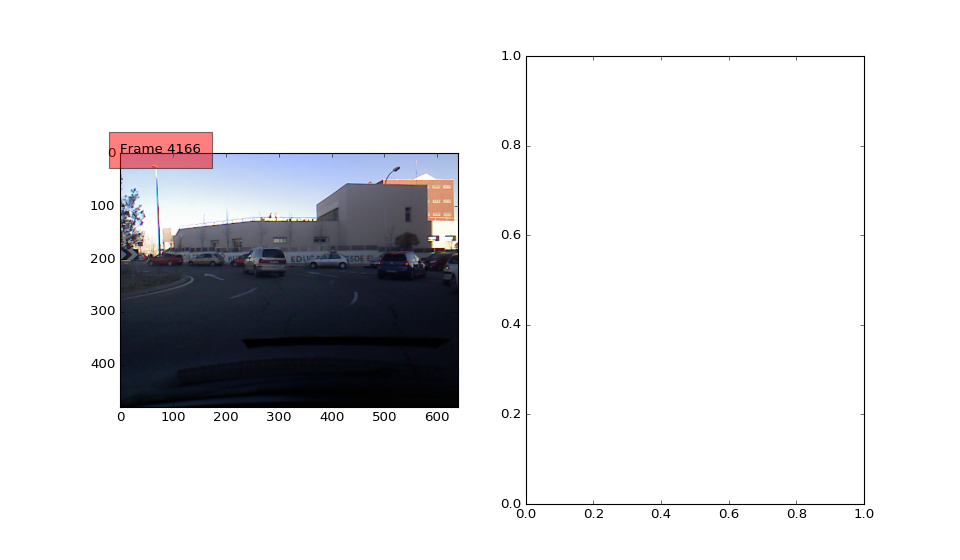

([(880, 898, 1),
  (2820, 2839, 1),
  (2844, 2867, -1),
  (3462, 3492, 1),
  (4140, 0, 1)],)

In [117]:
import time

fig, axs = plt.subplots(1, 2, figsize=(12, 7))

def plt_image(ax, index, path):
    image = mpimg.imread(path)
    ax.clear()
    ax.imshow(image)
    ax.text(0, 0, 'Frame ' + str(index), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

def plt_lidar(ax, path, columns):
    pc = PointCloud.load(path)
    ax.clear()
    ax.set_xlim((-35, 35))
    ax.set_ylim((-35, 35))
    ax.set_aspect('equal', adjustable='box')
    points = np.concatenate([np.array([pc.points[:,0]]).T, pc.points[:,1:]], axis=1) 
    points = np.concatenate([points, np.ones((len(pc.points),1))], axis=1) 
    points = np.matmul(points, lidar_calibration)
    mask = (points[:,2] > 0.5) & \
           (points[:,2] < 2) & \
           (points[:,0] < 35) & \
           (points[:,0] > 0.35) & \
           (points[:,1] < 1.5) & \
           (points[:,1] > -1.5)
    masked_points = points[mask,:2]
    other_points = points[np.logical_not(mask),:2]

    # Look for clusters
    n_clusters = 0
    n_points = len(masked_points)
    dist = np.inf
    if len(masked_points) > 0:
        db = DBSCAN(eps=.5, min_samples=10).fit(masked_points)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        for cluster in range(n_clusters):
            obs = masked_points[labels == cluster]
            dist = min(dist, np.sqrt(np.mean(obs[:, 0])**2 + np.mean(obs[:, 1])**2))
    columns.append((n_clusters, n_points))
    
    ax.scatter(other_points[:,0], other_points[:,1], s=.01, color='b', alpha=0.1);
    ax.scatter(masked_points[:,0], masked_points[:,1], s=.1, color='r');
    ax.text(-30, 30, 'Clusters: ' + str(n_clusters), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
    ax.text(-30, 20, 'Dist: ' + str(dist), bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

from_index = 4140

columns = []
for index, row in df.iterrows():
    if from_index is not None and from_index <= index:
        if not (pd.isnull(row['snapshots_path']) or pd.isnull(row['pointclouds_path'])):
            plt_image(axs[0], index, os.path.join(PATH, row['snapshots_path']))
            #plt_lidar(axs[1], os.path.join(PATH, row['pointclouds_path']), columns)

        fig.canvas.draw()
        time.sleep(.5)

[
    (880, 898, 1),(2820, 2839, 1),(2844, 2867, -1),(3462, 3492, 1),
    (4140, 4158, 1)
],

In [ ]:
sequences = {
    'edgar': {
        'training': [
            (100, 250),(400, 500),(510, 570),(800, 960),(1100, 1225),
            (1960, 2010),(2060, 2110),(2180, 2270),(2360, 2600),(2765, 2950),
            (3280, 3670),(4070, 4130),(4160, 4310),(4420, 4570),(4700, 4800),
            (4860, 4940),(5000, 5080),(5695, 5800),(5880, 5960),(6180, 6200),
            (6650, 6740),(6830, 6880),(6995, 7060),(7140, 7300),(7330, 7500),
            (7520, 7560),(7620, 7690),(7760, 7900),(7920, 7980),(8120, 8220),
            (8310, 8410),(8800, 8900),(9020, 9460),(9500, 9580),
        ],
        'validation': [
            (0, 80),(110, 300),(350, 540),(720, 820),(850, 900),(1440, 1670),
            (1900, 1980),(2500, 2730),(3030, 3160),(3270, 3380),(3550, 3690),
            (3890, 3910),(3960, 4000),(4080, 4440),
        ],
    },
    'jj': {
        'training': [
            (0, 100),(150 255),(950, 1110),(1111, 1300),(1520, 1660),
            (1700, 1860),(1900, 2020),(2160, 2250),(2430, 2550),(2551, 2695),
            (2900, 3080),(3160, 3250),(3260, 3340),(3660, 3705),(3860, 4200),
            (4710, 4780),(4836, 5200),(5310, 5610),(5890, 6050),(6420, 6540),
            (6780, 6820),(6821, 7000),(7180, 7280),(7350, 7777),(8620, 8900),
            (9265, 9350),(9520, 9930),(9980, 10150),(10230, 10400),
        ],
        'validation': [
            (250, 360),(415, 545),(630, 700),(900, 1130),(1280, 1400),
            (1550, 1700),(1750, 1920),(2220, 2540),(2590, 2800),(3000, 3300),
            (3610, 3780),(3800, 4025),(4030, 4140),(5000, 5100),(5650, 5725),
            (5880, 6020),(6420, 6575),(6630, 6740),(6960, 7030),(7100, 7250),
            (7590, 7780),(7800, 7870),(7890, 8050),(8270, 8620),(9010, 9690),
            (9850, 9900),
        ],
    },
    'miguel': {
        'training': [
            (0, 220),(230, 415),(1185, 1580),(1600, 1900),(2020, 2150),
            (2380, 2510),(2645, 3020),(3215, 3480),(3600, 3880),(3920, 4065),
            (4485, 4580),(4650, 4710),(4730, 4980),(5130, 5485),(5550, 5790),
            (6080, 6340),(6590, 6800),(7580, 7800),(7920, 8500),(8820, 8950),
            (9130, 10200),
        ],
        'validation': [],
    },
}